# Research Engineer test task

Dear applicant!
We are asking you to implement a thoughtful pipeline for a rather simple toy task.

You are given the dataset from the Tiny ImageNet Challenge which is the default final project for Stanford [CS231N](http://cs231n.stanford.edu/) course. It runs similar to the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/2014/) (ILSVRC). The goal of the original challenge is for you to do as well as possible on the Image Classification problem.

Although your goal of this task is **not** just to do as good as possible on the Image Classification problem.
We would rather encourage you to demonstrate best practices and your skills of rapid prototyping reliable pipelines.
You may want to take a look at Andrej Karpathy's [Recipe for Training Neural Networks
](https://karpathy.github.io/2019/04/25/recipe/).

We provided you with a simple pytorch baseline. You are free to use it or to design the whole solution from scratch. 
We are not restricting you with the frameworks, you can install any package you need and organise your files however you want. Just please make sure to provide all the sources, checkpoints, logs, visualisations etc.
If you decide to use our platform setup, it is all already taken care of. We will just review the artifacts of your work on our storage. Otherwise it is your responsibility.

To add some measurable results to the task, your final goal will be to achieve best accuracy on the provided __test__ split of the Tiny ImageNet dataset.
Also you are expected to show all the visualisations you find necessary alongside with the final evaluation metrics. We already took care of a tensorboard setup for you, so you can track some of your plots there. Please follow  [README.md](https://github.com/neuromation/test-task/blob/master/README.md) for instructions. 

In [1]:
%%capture

from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
from torch.utils.data.dataset import Dataset
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image
from torchvision import transforms, datasets

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

# Getting the data

In [2]:
PROJECT = Path('../')

In [3]:
DATA_PATH = Path('../data')

In [ ]:
# !! wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -O $DATA_PATH/tiny-imagenet-200.zip

Unpacking our dataset will take a while, but it will only have to be done once.

Be prepared to wait next cell to finish up to 15 minutes

In [ ]:
# !! [ ! -d $DATA_PATH/tiny-imagenet-200 ] && unzip $DATA_PATH/tiny-imagenet-200.zip -d $DATA_PATH

# Dataset

Here is a `TinyImagenetDataset` warpper you might find useful.

In [4]:
Transform = Callable[[Image.Image], Image.Image]


@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )

In [5]:
DATA_ROOT = Path(DATA_PATH / "tiny-imagenet-200")
RESULTS_ROOT = Path(PROJECT / "results/")
CHECKPOINTS = RESULTS_ROOT / "checkpoints"
CHECKPOINTS.mkdir(parents=True, exist_ok=True)
TENSORBOARD_TAG = "first_try"
CKPT_NAME = "first_model.pt"
CKPT_PATH = CHECKPOINTS / CKPT_NAME
DEVICE = torch.device("cuda")

In [6]:
TRAIN_PATH = DATA_ROOT / "train"
VAL_PATH = DATA_ROOT / "val"
ALL_FOLDERS = [
    dir_name
    for r, d, f in os.walk(TRAIN_PATH)
    for dir_name in d
    if dir_name != "images"
]
ALL_FOLDERS.sort()
FOLDERS_TO_NUM = {val: index for index, val in enumerate(ALL_FOLDERS)}

LABELS = pd.read_csv(
    DATA_ROOT / "words.txt", sep="\t", header=None, index_col=0)[1].to_dict()
VAL_LABELS = pd.read_csv(
    DATA_ROOT / "val" / "val_annotations.txt", sep="\t", header=None, index_col=0)[1].to_dict()

In [7]:
class TinyImagenetDataset(Dataset):
    _transform: Optional[Transform]
    _root: Path
    df: DataFrame

    def __init__(self, path, transform: Optional[Transform] = None):
        self._transform = transform
        if not os.path.isdir(path):
            raise NotADirectoryError(f"{path} is not a directory.")
        all_files = [
            os.path.join(r, fyle)
            for r, d, f in os.walk(path)
            for fyle in f
            if ".JPEG" in fyle
        ]
        all_files.sort() # So we can repeat results
        labels = [
            FOLDERS_TO_NUM.get(
                os.path.basename(f).split("_")[0],
                FOLDERS_TO_NUM.get(VAL_LABELS.get(os.path.basename(f))),
            )
            for f in all_files
        ]
        self.df = pd.DataFrame({"path": all_files, "label": labels})

    def __getitem__(self, index: int) -> DatasetItem:
        path, label = self.df.loc[index, :]
        image = Image.open(path).convert("RGB")
        if self._transform:
            image = self._transform(image)
        return DatasetItem(image=image, label=label, id=index, path=path)

    def __len__(self) -> int:
        return len(self.df)

# Training loop

# Main idea

Since the dataset is rather small we use quite heavy image augmentation. Also here we resize images to 224, since the ImageNet models are trained on the images of this size. Then we fine-tune the model on our images.

In [8]:
train_transform = transforms.Compose(
    [
        transforms.Resize(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.RandomErasing(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        
    ]
)

train_dataset = TinyImagenetDataset(DATA_ROOT / "train", train_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4,
)

test_transform = transforms.Compose(
    [
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

test_dataset = TinyImagenetDataset(DATA_ROOT / "val" / "images", test_transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    collate_fn=DatasetItem.collate,
    num_workers=4,
)

Show augmented images, check if the output is what we want it to bee

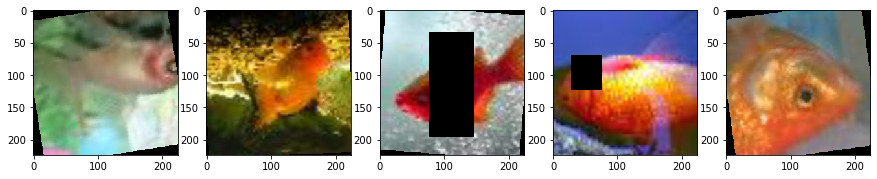

In [9]:
fig,ax = plt.subplots(1,5, figsize=(15,3))

for i in range(5):
    data_item = train_dataset[i]
    inp = data_item.image
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array( [0.2302, 0.2265, 0.2262])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax[i].imshow(inp) 

### Check if the data is balanced. 

Top-5 least frequent classes

In [10]:
train_data = train_dataset.df
temp = pd.DataFrame(train_data.label.value_counts().tail(5))
temp.reset_index(inplace=True)
temp.columns = ['label','count']
temp

,label,count
0,168,500
1,104,500
2,40,500
3,167,500
4,0,500


Top-5 most frequent classes

In [11]:
temp = pd.DataFrame(train_data.label.value_counts().head(5))
temp.reset_index(inplace=True)
temp.columns = ['label','count']
temp

,label,count
0,191,500
1,18,500
2,85,500
3,21,500
4,148,500


Define functions to save and load checkpoint

In [12]:
def save_ckp(state, save_every, checkpoint_path):
    """
    state: checkpoint we want to save
    save_every: number beetween each save
    checkpoint_path: path to save checkpoint
    """
    f_path = checkpoint_path
    epoch = state["epoch"]
    # save checkpoint data to the path given, checkpoint_path
    if (epoch % save_every) == 0:
        torch.save(state, f_path)
        print(f'Saved checkpoint at epoch {state["epoch"]}')
          
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min

In [13]:
def train(model, device, train_loader, optimizer, scheduler, loss_function, epoch, writer):
    model.train()
    model.to(device)
    correct = 0
    for batch_idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(
        "Train Epoch: {} [ ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch, 100.0 * correct / len(train_loader.dataset), loss.item()
        )
    )
    writer.add_scalar("train_loss_plot", loss.item(), global_step=epoch)
    writer.add_scalar(
        "train_accuracy_plot",
        100.0 * correct / len(train_loader.dataset),
        global_step=epoch,
    )
    
    checkpoint = {
            'epoch': epoch,
            'valid_loss_min': loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
    # save checkpoint
    save_path = CHECKPOINTS / Path(str(epoch) + '_' + CKPT_NAME)
    save_ckp(checkpoint, 2, save_path)
        

def test(model, device, test_loader, loss_function, epoch, writer):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            data, target = batch_data.images.to(device), batch_data.labels.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    if writer is not None:
        writer.add_scalar("test_loss_plot", test_loss, global_step=epoch)
        writer.add_scalar(
            "test_accuracy_plot",
            100.0 * correct / len(test_loader.dataset),
            global_step=epoch,
        )

Since we are using Tiny ImageNet in this task, in order to get good results we are simply going to use pretrained ResNet models and then fine-tune them on our dataset.

In [14]:
# model = EfficientNet.from_name('efficientnet-b1')
model = models.resnet34(pretrained=True)

# New layer will be trainable by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)
model = model.to(DEVICE)
num_epochs = 20
start_epoch = 0

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5)

loss_function = loss.CrossEntropyLoss()

In [15]:
save_path = CHECKPOINTS / Path('resnet34_val70_224pix.pt')
if os.listdir(CHECKPOINTS):
    model, optimizer, start_epoch, valid_loss_min = load_ckp(save_path, model, optimizer)
    start_epoch += 1

In [16]:
# writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)
# for epoch in range(start_epoch, num_epochs):
#     train(model, DEVICE, train_loader, optimizer, scheduler, loss_function, epoch, writer)
#     test(model, DEVICE, test_loader, loss_function, epoch, writer)

# writer.close()

In [18]:
test(model, DEVICE, test_loader, loss_function, 0, None)



Test set: Average loss: 0.0117, Accuracy: 7056/10000 (71%)



# Visualisation

Here is also a confusion matrix plot for you

In [19]:
import sklearn
import numpy as np
from matplotlib import pyplot as plt

In [20]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([200, 200], int)

with torch.no_grad():
    for item in tqdm(test_loader):
        images, labels = item.images.to(DEVICE), item.labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

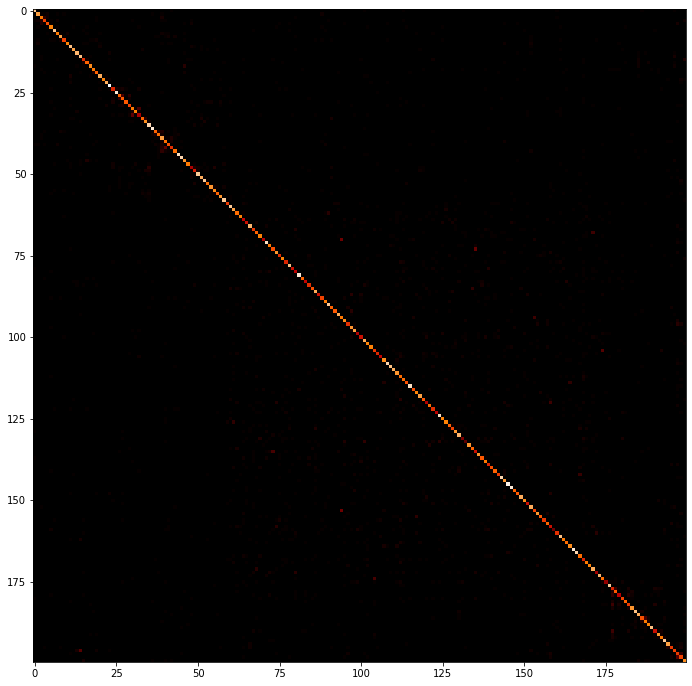

In [21]:
plt.figure(figsize=(12, 12))
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()